In [4]:
import random
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
# Preprocess the image data read in
def transform_img(img):
    # Scale the image size to 384x384
    if img is not None:
        img = cv2.resize(img, (384, 384))
        # The image data format read in is[H, W, C]
        # Use the transpose operation to turn it into[C, H, W]

        img = np.transpose(img, (2,0,1))
        img = img.astype('float32')
        # Adjust the data range to [-1.0, 1.0]
        img = img / 255.
        img = img * 2.0 - 1.0
    return img

# Define the training set data reader
def data_loader(datadir, batch_size=10, mode = 'train'):

    filenames = os.listdir(datadir)
    def reader():
        if mode == 'train':
            random.shuffle(filenames)
        batch_imgs = []
        batch_labels = []
        for name in filenames:
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            if name[0] == 'H' or name[0] == 'N':
                # File names starting with H indicate high shortsighted, and file names starting with N indicate normal vision
                # label is 0
                label = 0
            elif name[0] == 'P':
               # The beginning of P is pathological myopia, which belongs to the positive sample, and the label is 1
                label = 1
            else:
                print('Not excepted file name')
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
               # When the length of the data list is equal to batch_size,
                 # Treat these data as a mini-batch and use it as an output of the data generator
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader


def valid_data_loader(datadir, csvfile, batch_size=10, mode='valid'):
    filelists = open(csvfile).readlines()
    def reader():
        batch_imgs = []
        batch_labels = []
        for line in filelists[1:401]:
            line = line.strip().split(',')
            name = line[1]
            #print(line[2])
            label = int(line[2])
            # Load the image according to the image file name and preprocess the image data
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            # Every time the data of a sample is read, put it into the data list
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader


In [5]:
import torch
import torchvision

DATADIR = './data/eye/training/PALM-Training400/PALM-Training400/'
train_loader = data_loader(DATADIR, 
                           batch_size=5, mode='train')
data_reader = train_loader()
data = next(data_reader)
data[0].shape, data[1].shape

Not excepted file name


/var/folders/93/qybn6zk512d1krk3jjwc2qqw0000gn/T/ipykernel_34307/2757098994.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgs_array = np.array(batch_imgs).astype('float32')


ValueError: setting an array element with a sequence.

In [ ]:
DATADIR2 = './data/eye/validation/PALM-Validation400'
CSVFILE = './data/eye/valid_gt/PALM-Validation-GT/labels.csv'
valid_loader = valid_data_loader(DATADIR2, CSVFILE,batch_size=5,mode='valid')
data_reader = valid_loader()
data = next(data_reader)
data[0].shape, data[1].shape

In [6]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = 400
    model.train()

    for i, DATA in enumerate(data_loader()):
        data, target = DATA
        target=target.squeeze()
        data=torch.tensor(data)
        #target=torch.tensor(target)
        target = torch.Tensor(target).long()
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
#         print(output)
#         print(target)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 40 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / (400/5)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

In [2]:
def evaluate(model, data_loader, loss_history):
    model.eval()
    
    total_samples = 400
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for i, DATA in enumerate(data_loader()):
            data, target = DATA
            target=target.squeeze()
            data=torch.tensor(data)
            target = torch.Tensor(target).long()
            output = F.log_softmax(model(data), dim=1)
            #print(output)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [8]:
import torch
import torch.nn.functional as F

from torch import nn
from einops import rearrange
import time

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, dropout,emb_dropout, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [10]:
N_EPOCHS = 8

start_time = time.time()
model = ViT(
    image_size=384, 
    patch_size=16, 
    num_classes=2, 
    channels=3, 
    dim=64, #D
    depth=6, #number of encoder
    heads=4, 
    mlp_dim=128, #feedbackw dim
    dropout = 0.1,
    emb_dropout = 0.1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.004)

train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, valid_loader, test_loss_history)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/  400 (  0%)]  Loss: 0.6753
[  200/  400 ( 50%)]  Loss: 0.6562

Average test loss: 0.6274  Accuracy:  218/  400 (54.50%)

Epoch: 2
[    0/  400 (  0%)]  Loss: 0.6270
[  200/  400 ( 50%)]  Loss: 0.6214

Average test loss: 0.6225  Accuracy:  235/  400 (58.75%)

Epoch: 3
[    0/  400 (  0%)]  Loss: 0.5472
[  200/  400 ( 50%)]  Loss: 0.6773

Average test loss: 0.5790  Accuracy:  326/  400 (81.50%)

Epoch: 4
[    0/  400 (  0%)]  Loss: 0.5157
[  200/  400 ( 50%)]  Loss: 0.4004

Average test loss: 0.5320  Accuracy:  300/  400 (75.00%)

Epoch: 5
[    0/  400 (  0%)]  Loss: 1.3962
[  200/  400 ( 50%)]  Loss: 0.3427

Average test loss: 0.2741  Accuracy:  354/  400 (88.50%)

Epoch: 6
[    0/  400 (  0%)]  Loss: 0.3211
[  200/  400 ( 50%)]  Loss: 0.9905

Average test loss: 0.4778  Accuracy:  329/  400 (82.25%)

Epoch: 7
[    0/  400 (  0%)]  Loss: 0.6407
[  200/  400 ( 50%)]  Loss: 0.6408

Average test loss: 0.4204  Accuracy:  323/  400 (80.75%)

Epoch: 8
[    0/  400 (  0%)]  Los

examples = enumerate(valid_loader())
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

In [130]:
#torch.save(model.state_dict(), 'model-vit-eye.pth')

Label: 1 , Predicted: 1


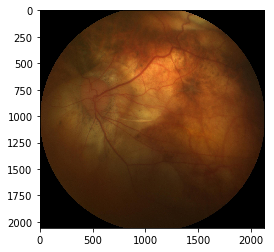

In [16]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb =  model(img)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

DATADIR2 = './data/eye/validation/PALM-Validation400/'
CSVFILE = './data/eye/valid_gt/PALM-Validation-GT/labels.csv'
line=333
filelists = open(CSVFILE).readlines()

content = filelists[line].strip().split(',')
name=content[1]
label=content[2]
img = Image.open(os.path.join(DATADIR2, name))
img = np.array(img)
plt.imshow(img)

filepath = os.path.join(DATADIR2, name)
img = cv2.imread(filepath)
img = transform_img(img)
img=torch.tensor(img)
img=img.unsqueeze(0)
        
print('Label:', label, ', Predicted:', predict_image(img, model))  

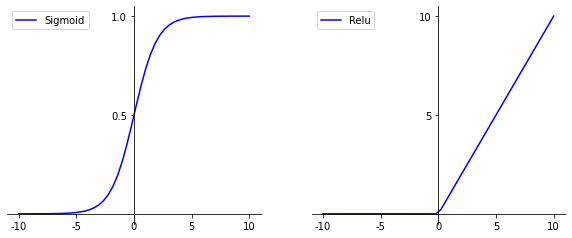

In [6]:
import math
plt.rcParams['axes.unicode_minus'] = False
 
def sigmoid(x):
    result = 1/(1+math.e**(-x))
    return result
 
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
x = np.linspace(-10,10)
y = sigmoid(x)
 
ax.spines['top'].set_color('none')  
ax.spines['right'].set_color('none')  
 
ax.xaxis.set_ticks_position('bottom')  
ax.spines['bottom'].set_position(('data',0))  
ax.set_xticks([-10,-5,0,5,10])  
ax.yaxis.set_ticks_position('left')  
ax.spines['left'].set_position(('data',0))  
ax.set_yticks([-1,-0.5,0.5,1])  
 
plt.plot(x,y,label = "Sigmoid",linestyle='-',color='blue')
plt.legend()
 


def relu(x):
    result=np.maximum(0,x)
    return result
 

ax = fig.add_subplot(122)
x = np.linspace(-10,10)
y = relu(x)
 
ax.spines['top'].set_color('none')  
ax.spines['right'].set_color('none')  
 
ax.xaxis.set_ticks_position('bottom')  
ax.spines['bottom'].set_position(('data',0))  
ax.set_xticks([-10,-5,0,5,10])  
ax.yaxis.set_ticks_position('left')  
ax.spines['left'].set_position(('data',0))  
ax.set_yticks([5,10])  
 
plt.plot(x,y,label = "Relu",linestyle='-',color='blue')
plt.legend()
plt.show()

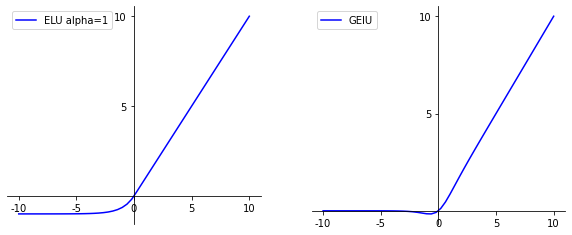

In [7]:
def elu(x,alpha=1):
    a = x[x>0]
    b = alpha*(math.e**(x[x<0])-1)
    result=np.concatenate((b,a),axis=0)
    return result

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
x = np.linspace(-10,10)
y = elu(x)
 
ax.spines['top'].set_color('none')  
ax.spines['right'].set_color('none')  
 
ax.xaxis.set_ticks_position('bottom')  
ax.spines['bottom'].set_position(('data',0))  
ax.set_xticks([-10,-5,0,5,10])  
ax.yaxis.set_ticks_position('left')  
ax.spines['left'].set_position(('data',0))  
ax.set_yticks([5,10])  
 
plt.plot(x,y,label = "ELU alpha=1",linestyle='-',color='blue')
plt.legend()
plt.savefig('Relu an ELU.png',dpi=200)

def sigmod(x):
    return 1.0/(1+np.exp(-x))

def gelu(x):
    # return 0.5*x*(1+ np.tanh(np.sqrt(2/np.pi)*(x+0.044715*np.power(x,3))))
    return x*sigmod(1.702*x)

# fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(122)
x = np.linspace(-10,10)
y = gelu(x)
 
ax.spines['top'].set_color('none')  
ax.spines['right'].set_color('none')  
 
ax.xaxis.set_ticks_position('bottom')  
ax.spines['bottom'].set_position(('data',0))  
ax.set_xticks([-10,-5,0,5,10])  
ax.yaxis.set_ticks_position('left')  
ax.spines['left'].set_position(('data',0))  
ax.set_yticks([5,10])  
 
plt.plot(x,y,label = "GElU",linestyle='-',color='blue')
plt.legend()
plt.savefig('sigmoid and tanh.png',dpi=200)
plt.show()

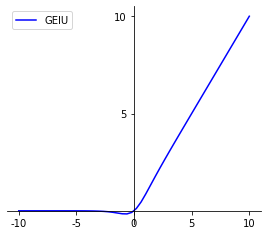

In [8]:
def sigmod(x):
    return 1.0/(1+np.exp(-x))

def gelu(x):
    # return 0.5*x*(1+ np.tanh(np.sqrt(2/np.pi)*(x+0.044715*np.power(x,3))))
    return x*sigmod(1.702*x)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
x = np.linspace(-10,10)
y = gelu(x)
 
ax.spines['top'].set_color('none')  
ax.spines['right'].set_color('none')  
 
ax.xaxis.set_ticks_position('bottom')  
ax.spines['bottom'].set_position(('data',0))  
ax.set_xticks([-10,-5,0,5,10])  
ax.yaxis.set_ticks_position('left')  
ax.spines['left'].set_position(('data',0))  
ax.set_yticks([5,10])  
 
plt.plot(x,y,label = "GElU",linestyle='-',color='blue')
plt.legend()
plt.show()